In [1]:
import os
import matplotlib.pyplot as plt
from utils import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import *

In [3]:
 
# For now these only apply for the HSI data, but eventually we will only need that
TRAIN_FOLDER = "../Data/HDF5_FILES/train"
MASK_FOLDER = "../Data/MASKS/train"
BATCH_SIZE = 2
MASK_METHOD = 1    # 0 for only leaf, 1 for leaf+stem

In [4]:
hsi_np, wlens = LoadHSI("C:/Users/leonw/OneDrive - KU Leuven/Master Thesis/Data_cropped/cropped_hdf5/FX10_08SEPT2023_4C3_2.hdf5", return_wlens=True)
mask_np = read_mask("C:/Users/leonw/OneDrive - KU Leuven/Master Thesis/Data_cropped/cropped_masks/FX10_08SEPT2023_4C3_2.png")

In [5]:
from scipy.signal import savgol_filter
def preprocess(hsi_np, wlens, min_wavelength=0, normalize=True, selected_bands=None):
    """
    Removes spectral bands with wavelengths below min_wavelength from the hyperspectral image.
    Also replaces negative values with 0 and applies optional normalization.
    Also apply optional band selection, but that is inteded to be used in the dataset class 
    after determining selected bands based on PCA loadings.

    Parameters:
    - hsi_np (nunmpy array): Hyperspectral image with shape (bands, height, width).
    - wlens (numpy array): Wavelength values with shape (bands, ) corresponding to bands in hsi_np
    - min_wavelength (int or float): Minimum wavelength (in nm) to keep in the hyperspectral data
    - normalize (bool): Whether to normalize the hyperspectral image data
    - selected_bands (list or None): List of exact wavelength values to keep. If None, all bands >= min_wavelength are kept.

    Returns:
    - hsi_np_filtered (numpy array): Hyperspectral image with selected spectral bands of shape (filtered bands, height, width)
    - wlens_filtered (numpy array): Updated wavelengths array of shape (filtered bands, )
    """
    # Determine wavelengths to keep
    valid_bands = wlens >= min_wavelength  

    # Filter hsi_np and wlens to keep only relevant bands
    hsi_np_filtered = hsi_np[valid_bands, :, :]
    wlens_filtered = wlens[valid_bands]
    
    # Set all negative values to 0 (these are noise)
    hsi_np_filtered = np.maximum(hsi_np_filtered, 0)
    
    # Normalize the data if required
    if normalize and np.max(hsi_np_filtered) > 0:    # Avoid division by zero
        hsi_np_filtered = hsi_np_filtered / np.max(hsi_np_filtered)
    
    # Perform band selection - will mainly be used in the dataset class for dimensionality reduction
    if selected_bands is not None:
        selected_bands = np.sort(selected_bands)
        # Get indices of the selected bands in wlens_filtered
        selected_band_indices = np.searchsorted(wlens_filtered, selected_bands)
        # Filter hsi_np and wlens to keep only selected bands
        hsi_np_filtered = hsi_np_filtered[selected_band_indices, :, :]
        wlens_filtered = wlens_filtered[selected_band_indices]
        
    return hsi_np_filtered, wlens_filtered

def apply_snv(hyper_image):
    # Input shape: (bands, H, W)
    bands, H, W = hyper_image.shape

    # Reshape to (H*W, bands) — each row is one pixel's spectrum
    pixel_spectra = hyper_image.reshape(bands, -1).T  # shape: (H*W, bands)

    # Apply SNV: subtract mean and divide by std per pixel
    mean = pixel_spectra.mean(axis=1, keepdims=True)
    std = pixel_spectra.std(axis=1, keepdims=True)
    snv_pixel_spectra = (pixel_spectra - mean) / (std + 1e-8)

    # Reshape back to (bands, H, W)
    snv_image = snv_pixel_spectra.T.reshape(bands, H, W)
    return snv_image

def preprocessing_snv(hsi_np, wlens, min_wavelength=0, selected_bands=None):
    """
    Removes spectral bands with wavelengths below min_wavelength from the hyperspectral image.
    Also replaces negative values with 0 and applies optional normalization.
    Also apply optional band selection, but that is inteded to be used in the dataset class 
    after determining selected bands based on PCA loadings.

    Parameters:
    - hsi_np (nunmpy array): Hyperspectral image with shape (bands, height, width).
    - wlens (numpy array): Wavelength values with shape (bands, ) corresponding to bands in hsi_np
    - min_wavelength (int or float): Minimum wavelength (in nm) to keep in the hyperspectral data
    - normalize (bool): Whether to normalize the hyperspectral image data
    - selected_bands (list or None): List of exact wavelength values to keep. If None, all bands >= min_wavelength are kept.

    Returns:
    - hsi_np_filtered (numpy array): Hyperspectral image with selected spectral bands of shape (filtered bands, height, width)
    - wlens_filtered (numpy array): Updated wavelengths array of shape (filtered bands, )
    """
    # Determine wavelengths to keep
    valid_bands = wlens >= min_wavelength  
    # Filter hsi_np and wlens to keep only relevant bands
    hsi_np_filtered = hsi_np[valid_bands, :, :]
    wlens_filtered = wlens[valid_bands]
    # Set all negative values to 0 (these are noise)
    hsi_np_filtered = np.maximum(hsi_np_filtered, 0)

    hsi_np_snv = apply_snv(hsi_np_filtered)

    # Perform band selection - will mainly be used in the dataset class for dimensionality reduction
    if selected_bands is not None:
        selected_bands = np.sort(selected_bands)
        # Get indices of the selected bands in wlens_filtered
        selected_band_indices = np.searchsorted(wlens_filtered, selected_bands)
        # Filter hsi_np and wlens to keep only selected bands
        hsi_np_snv = hsi_np_snv[selected_band_indices, :, :]
        wlens_filtered = wlens_filtered[selected_band_indices]

    return hsi_np_snv, wlens_filtered

def savgol_filter_hypercube(hyper_image, window_length=11, polyorder=2, deriv = 2):
    """
    Apply Savitzky-Golay filter along the spectral axis (per pixel).

    Args:
        hyper_image: numpy array of shape (bands, H, W)
        window_length: Window size for the filter (must be odd)
        polyorder: Polynomial order for the filter

    Returns:
        Smoothed hyper_image of same shape
    """
    bands, H, W = hyper_image.shape

    # Make sure window length is valid and odd
    window_length = min(window_length, bands if bands % 2 else bands - 1)

    # Reshape to (H*W, bands) for per-pixel filtering
    reshaped = hyper_image.transpose(1, 2, 0).reshape(-1, bands)

    # Apply SG filter across the spectral dimension for each pixel
    smoothed = savgol_filter(reshaped, window_length=window_length, polyorder=polyorder, deriv = deriv, axis=1)

    # Reshape back to (bands, H, W)
    smoothed_cube = smoothed.reshape(H, W, bands).transpose(2, 0, 1)

    return smoothed_cube

def preprocessing_savgol(hsi_np, wlens, window_length=11, polyorder=2, deriv = 2, min_wavelength=0, selected_bands=None):
    """
    Removes spectral bands with wavelengths below min_wavelength from the hyperspectral image.
    Also replaces negative values with 0 and applies optional normalization.
    Also apply optional band selection, but that is inteded to be used in the dataset class 
    after determining selected bands based on PCA loadings.

    Parameters:
    - hsi_np (nunmpy array): Hyperspectral image with shape (bands, height, width).
    - wlens (numpy array): Wavelength values with shape (bands, ) corresponding to bands in hsi_np
    - min_wavelength (int or float): Minimum wavelength (in nm) to keep in the hyperspectral data
    - normalize (bool): Whether to normalize the hyperspectral image data
    - selected_bands (list or None): List of exact wavelength values to keep. If None, all bands >= min_wavelength are kept.

    Returns:
    - hsi_np_filtered (numpy array): Hyperspectral image with selected spectral bands of shape (filtered bands, height, width)
    - wlens_filtered (numpy array): Updated wavelengths array of shape (filtered bands, )
    """
    # Determine wavelengths to keep
    valid_bands = wlens >= min_wavelength  
    # Filter hsi_np and wlens to keep only relevant bands
    hsi_np_filtered = hsi_np[valid_bands, :, :]
    wlens_filtered = wlens[valid_bands]
    hsi_np_savgol = savgol_filter_hypercube(hsi_np_filtered, window_length,polyorder, deriv = deriv)

    # Perform band selection - will mainly be used in the dataset class for dimensionality reduction
    if selected_bands is not None:
        selected_bands = np.sort(selected_bands)
        # Get indices of the selected bands in wlens_filtered
        selected_band_indices = np.searchsorted(wlens_filtered, selected_bands)
        # Filter hsi_np and wlens to keep only selected bands
        hsi_np_savgol = hsi_np_savgol[selected_band_indices, :, :]
        wlens_filtered = wlens_filtered[selected_band_indices]

    return hsi_np_savgol, wlens_filtered

In [6]:
normalize_hsi_np, wlens_normalize= preprocess(hsi_np, wlens, min_wavelength=430, normalize=True, selected_bands=None)
snv_hsi_np, wlens_snv = preprocessing_snv(hsi_np, wlens, min_wavelength=430, selected_bands=None)
savgol_hsi_np_smooth, wlens_savgol_smooth = preprocessing_savgol(hsi_np, wlens, window_length=11, polyorder=2, deriv = 0, min_wavelength=430, selected_bands=None)
savgol_hsi_np_first, wlens_savgol_first = preprocessing_savgol(hsi_np, wlens, window_length=11, polyorder=2, deriv = 1, min_wavelength=430, selected_bands=None)
savgol_hsi_np_second, wlens_savgol_second = preprocessing_savgol(hsi_np, wlens, window_length=11, polyorder=2, deriv = 2, min_wavelength=430, selected_bands=None)

In [7]:
type(normalize_hsi_np)

numpy.ndarray

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_spectra(hsi_np, mask_np, wlens, nr_sample, seed=None,
                 method="none",
                 file_path="C:/Users/leonw/OneDrive - KU Leuven/Master Thesis/Visualizations thesis/Preprocessing/"):
    # Find relevant indices where the mask equals 1
    relevant_indices = np.argwhere(mask_np == 1)
    
    # Set the random seed if provided
    if seed is not None:
        np.random.seed(seed)
    
    # Randomly sample the relevant indices
    sample_indices = relevant_indices[
        np.random.choice(len(relevant_indices),
                         size=min(nr_sample, len(relevant_indices)),
                         replace=False)
    ]
    
    # Initialize a list to store spectral values for averaging
    all_spectral_values = []
    
    # Create the figure
    plt.figure(figsize=(10, 5))
    
    # Plot the spectral values for the sampled pixels
    for (row, col) in sample_indices:
        spectral_values = hsi_np[:, row, col]
        all_spectral_values.append(spectral_values)
        plt.plot(
            wlens,
            spectral_values,
            color='lightblue',
            linewidth=0.4,
            alpha=0.2
        )
    
    # Convert the list to a numpy array for easier statistical computation
    all_spectral_values = np.array(all_spectral_values)
    
    # Compute the mean and standard deviation
    mean_spectral_values = np.mean(all_spectral_values, axis=0)
    std_spectral_values = np.std(all_spectral_values, axis=0)
    
    # Plot the mean spectral values as a thick dark blue line
    plt.plot(
        wlens,
        mean_spectral_values,
        color='darkblue',
        linewidth=3,
        label='Mean Spectral Value'
    )
    
    # Plot the standard deviation as shaded areas around the mean
    plt.fill_between(
        wlens,
        mean_spectral_values - std_spectral_values,
        mean_spectral_values + std_spectral_values,
        color='darkblue',
        alpha=0.8,
        label='±1 Std Dev'
    )
    
    # Customize ticks on both axes: fewer major ticks, larger labels
    ax = plt.gca()
    
    # X-axis: major ticks every 200 nm, minor ticks every 50 nm
    ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))
    
    # Y-axis: choose a suitable major locator based on data range
    # For example, if intensity ranges up to ~10000, major ticks every 2000
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=6, integer=True, prune='both'))
    ax.yaxis.set_minor_locator(ticker.NullLocator())
    
    # Increase the tick-label font size
    ax.tick_params(axis='x', which='major', labelsize=18)
    ax.tick_params(axis='x', which='minor', labelsize=0)  # Hide minor tick labels
    ax.tick_params(axis='y', which='major', labelsize=18)
    ax.tick_params(axis='y', which='minor', labelsize=0)
    
    # Add labels and legend
    plt.xlabel('Wavelength (nm)', fontsize=22)
    plt.ylabel('Intensity', fontsize=22)
    plt.xlim(430, 1000)
    plt.legend(fontsize=16)
    
    # Save the plot
    plt.savefig(f'{file_path}Spectra_Healthy_{method}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [18]:
savgol_hsi_np_smooth_snv, wlens_savgol_smooth_snv = preprocessing_savgol(snv_hsi_np, wlens_snv, window_length=11, polyorder=2, deriv = 0, min_wavelength=430, selected_bands=None)

In [27]:
import numpy as np

def minmax_scale_global(arr):
    """
    Perform min-max scaling over the entire 3D array,
    mapping values to [0,1] based on the global min and max.
    
    Parameters
    ----------
    arr : np.ndarray
        Your 3D HSI array, e.g., shape (bands, rows, cols).
    
    Returns
    -------
    scaled : np.ndarray
        Same shape as `arr`, with values in [0,1].
    """
    arr = arr.astype('float32')  # ensure float to avoid integer division
    global_min = arr.min()
    global_max = arr.max()
    
    # Avoid division by zero if array is constant
    if global_max == global_min:
        return np.zeros_like(arr)
    
    scaled = (arr - global_min) / (global_max - global_min)
    return scaled

In [28]:
savgol_hsi_np_smooth_scaled = minmax_scale_global(savgol_hsi_np_smooth)

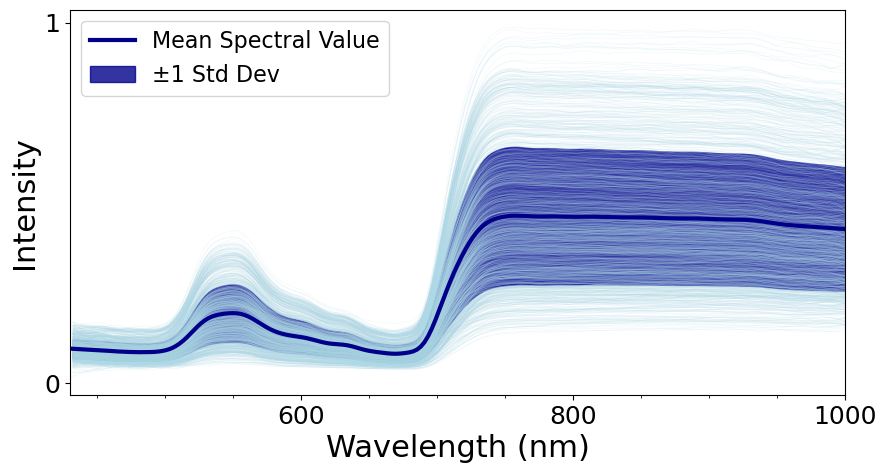

In [29]:
plot_spectra(savgol_hsi_np_smooth_scaled, mask_np, wlens_savgol_smooth, nr_sample=1000, seed=100, method = "Savgol_smooth")

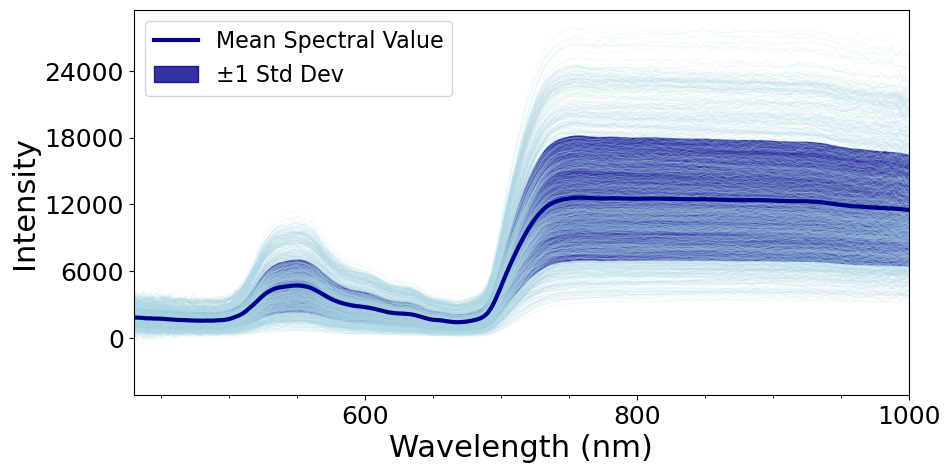

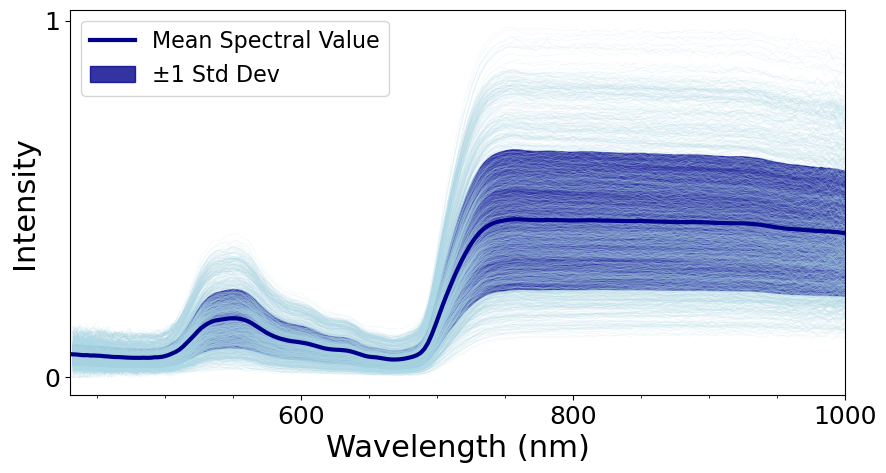

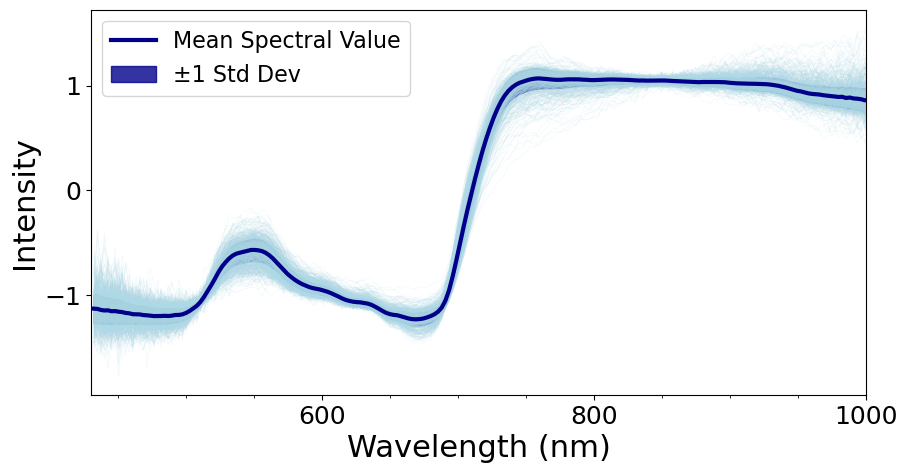

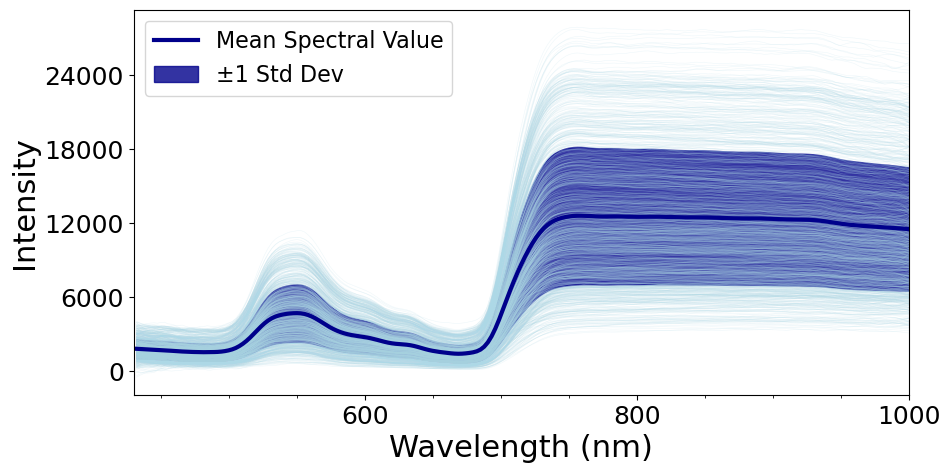

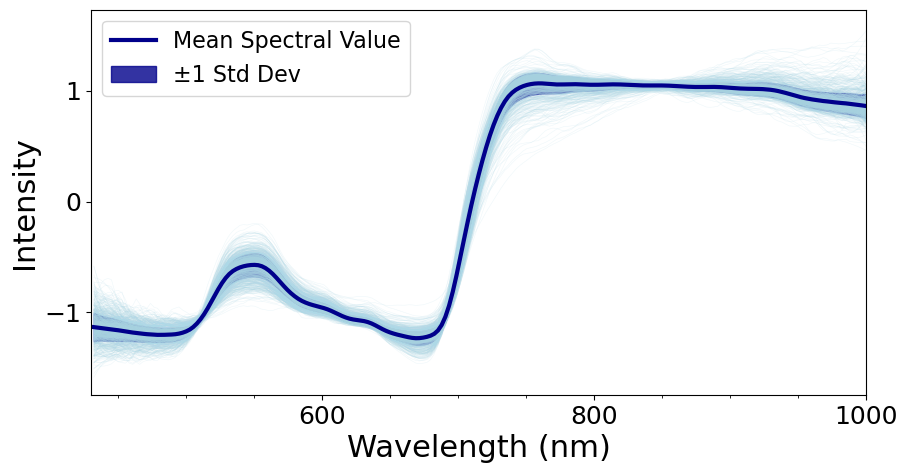

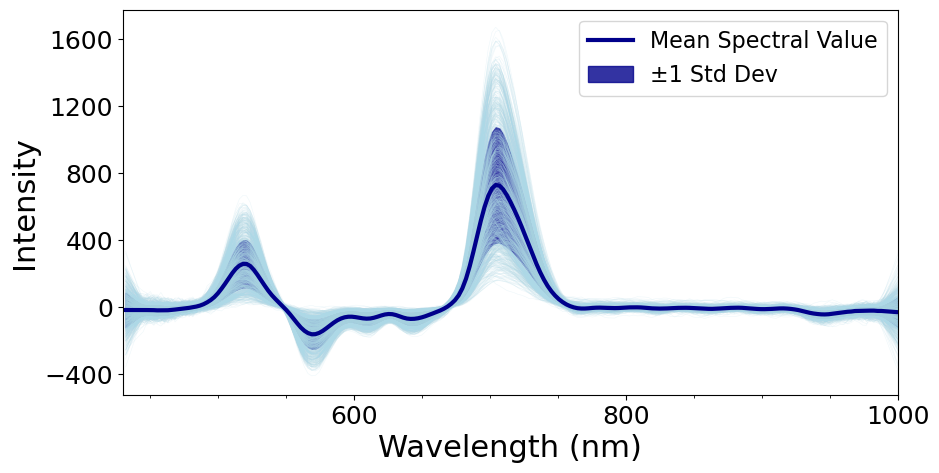

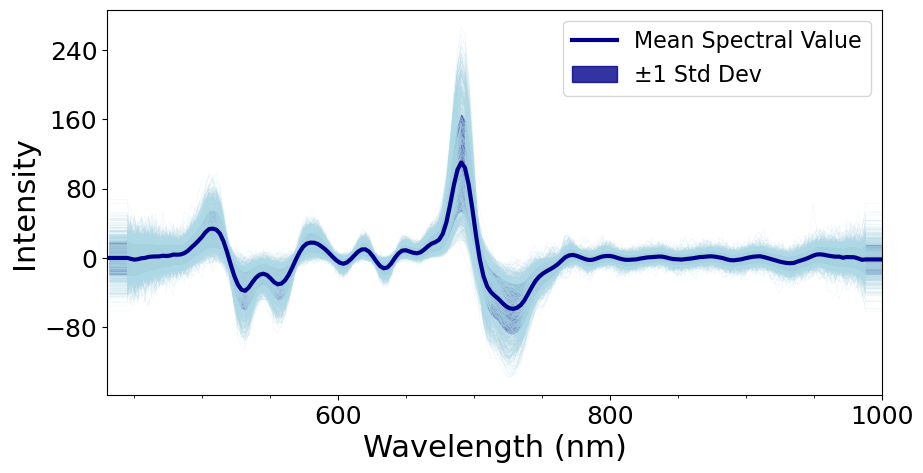

In [26]:
plot_spectra(hsi_np, mask_np, wlens, nr_sample=1000, seed=100, method = "Nopreprocess")
plot_spectra(normalize_hsi_np, mask_np, wlens_normalize, nr_sample=1000, seed=100, method = "MinMaxScaling")
plot_spectra(snv_hsi_np, mask_np, wlens_snv, nr_sample=1000, seed=100, method = "SNV")
plot_spectra(savgol_hsi_np_smooth, mask_np, wlens_savgol_smooth, nr_sample=1000, seed=100, method = "Savgol_smooth")
plot_spectra(savgol_hsi_np_smooth_snv, mask_np, wlens_savgol_smooth_snv, nr_sample=1000, seed=100, method = "Savgol_SNV")
plot_spectra(savgol_hsi_np_first, mask_np, wlens_savgol_first, nr_sample=1000, seed=100, method = "Savgol_first")
plot_spectra(savgol_hsi_np_second, mask_np, wlens_savgol_second, nr_sample=1000, seed=100, method = "Savgol_second")

In [9]:
bands, H, W = hsi_np.shape
reshaped = hsi_np.transpose(1, 2, 0).reshape(-1, bands)
mean = np.mean(reshaped, axis=1, keepdims = True)


In [17]:
std = np.std(reshaped, axis=1, keepdims=True)
snv_data = (reshaped - mean) / (std + 1e-8)  # small epsilon to avoid div by zero

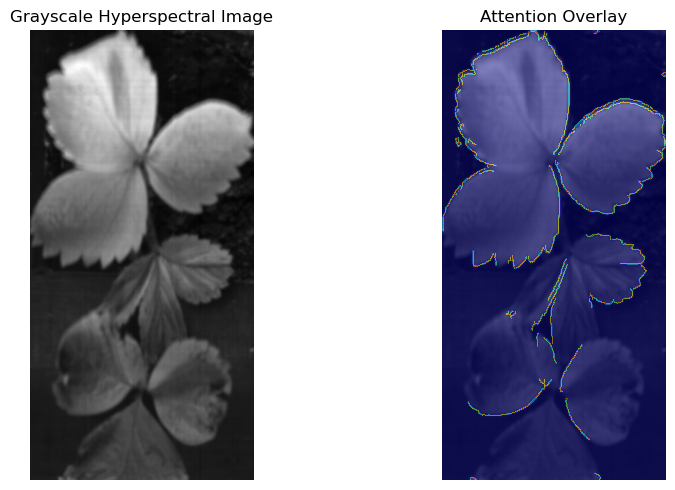

In [12]:
import matplotlib.pyplot as plt

# Assume hsi_np has shape [bands, H, W]
gray = hsi_np.mean(axis=0)  # average bands for grayscale visualization
attn = edges  # already computed attention map, shape [H, W]

# Normalize gray image for display
gray_norm = gray / (gray.max() + 1e-8)

plt.figure(figsize=(10, 5))

# Original grayscale image
plt.subplot(1, 2, 1)
plt.imshow(gray_norm, cmap='gray')
plt.title("Grayscale Hyperspectral Image")
plt.axis('off')

# Overlay attention as heatmap
plt.subplot(1, 2, 2)
plt.imshow(gray_norm, cmap='gray')
plt.imshow(attn, cmap='jet', alpha=0.5)  # heatmap overlay
plt.title("Attention Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()

c:\Users\leonw\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


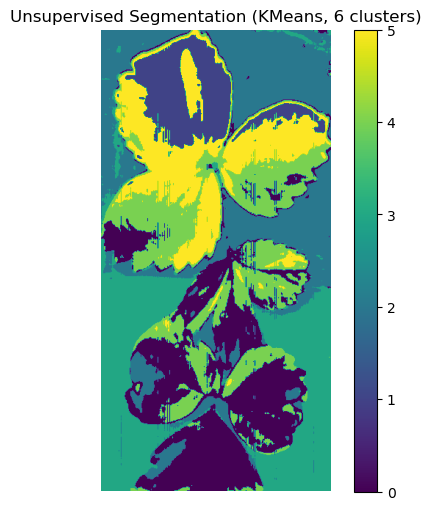

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Example input: hsi_np with shape (bands, H, W)
# Simulate or load your image here
# hsi_np = np.load("some_image.npy")  # or from DataLoader
bands, H, W = hsi_np.shape

# Reshape to (num_pixels, num_features)
X = hsi_np.reshape(bands, -1).T  # shape: (H*W, bands)

# Optional: normalize spectral features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply clustering (KMeans is fast, SpectralClustering is slower but can better handle structure)
n_clusters = 6  # Try different values; 2-5 often works well for leaf structure
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Reshape back to image dimensions
segmented_img = labels.reshape(H, W)

# Visualize segmented image
plt.figure(figsize=(6, 6))
plt.imshow(segmented_img, cmap='viridis')
plt.title(f"Unsupervised Segmentation (KMeans, {n_clusters} clusters)")
plt.axis('off')
plt.colorbar()
plt.show()